In [98]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Get Energy of H2 molecule from samples

In [2]:
folder = "H2_data/"
filename_wvfct = "R_0.2_psi.txt"
filename_samples = "R_0.2_samples.txt"

samples = np.loadtxt(folder + filename_samples)
wvfct = np.loadtxt(folder + filename_wvfct)

### Load coefficients

The coefficients are from https://arxiv.org/pdf/1512.06860.pdf from the appendix

In [3]:
coeff = np.loadtxt("H2_coefficients.txt")

### Find frequency / probability of all measurements

In [4]:
basis = np.array([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])

def find_sample_frequency(samples):
    freq = []
    for b in basis:
        l = len(np.where((samples == b).all(axis=1))[0])
        freq.append(l)
    return np.array(freq) / samples.shape[0]

freq = find_sample_frequency(samples)
print(freq)

[0.     0.0015 0.9985 0.    ]


### Define all operators of Hamiltonian

In [5]:
def one(freq):
    return freq.sum()

def Z0(freq):
    return freq[:2].sum() - freq[2:4].sum()

def Z1(freq):
    return freq[[0,2]].sum() - freq[[1,3]].sum()

def Z0Z1(freq):
    return freq[[0,3]].sum() - freq[[1,2]].sum()

def X0X1(freq):
    return 2*np.sqrt(freq)[[1,2]].prod() + 2*np.sqrt(freq)[[0,3]].prod()

def Y0Y1(freq):
    return 2*np.sqrt(freq)[[1,2]].prod() - 2*np.sqrt(freq)[[0,3]].prod() # Y0Y1 gives minus sign to [00] and [11]

In [6]:
print(np.sqrt(freq)[[1,2]])

print(Z0(freq))

[0.03872983 0.99924972]
-0.9970000000000001


### Define Hamiltonian

In [73]:
def energy(samples, coeff):
    f = find_sample_frequency(samples)
    c1, c2, c3, c4, c5, c6 = coeff[1:-1]
    return c1*one(f) + c2*Z0(f) + c3*Z1(f) + c4*Z0Z1(f) - c5*X0X1(f) - c5*Y0Y1(f)

In [74]:
energy(samples, coeff[0])

1.7805107063286294

### Get all the energies for different R

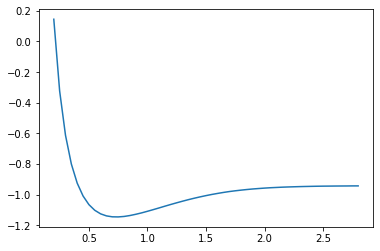

In [99]:
energies = []
x_axis = []
for i in tqdm(range(53)):
    R = coeff[i][0]
    try: 
        filename_samples = "R_{}_samples.txt".format(R)
        samples = np.loadtxt(folder + filename_samples)
        E = energy(samples, coeff[i])
        energies.append(E)
        x_axis.append(R)
    except:
        print("No sample file for R = {}".format(R))
        
plt.plot(x_axis, energies)
plt.show()

## Confirm result with wavefunction

In [76]:
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
Y = 1j*np.array([[0,-1],[1,0]])

In [77]:
def ex_one():
    return np.eye(4)

def ex_Z0():
    return np.kron(np.eye(2), Z)

def ex_Z1():
    return np.kron(Z, np.eye(2))

def ex_Z0Z1():
    return np.kron(Z, Z)

def ex_X0X1():
    return np.kron(X, X)

def ex_Y0Y1():
    return np.kron(Y, Y)

In [78]:
def energy_exact(wave_fct, coeff):
    w = wave_fct
    c1, c2, c3, c4, c5, c6 = coeff[1:-1]
    H = c1*ex_one() + c3*ex_Z0() + c2*ex_Z1() + c4*ex_Z0Z1() - c5*ex_X0X1() - c5*ex_Y0Y1()
    w1 = H.dot(w)
    return np.inner(w, w1)

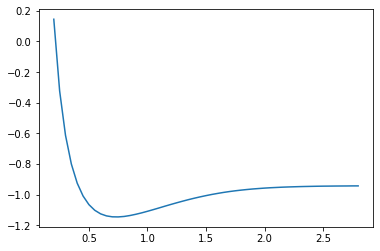

In [101]:
energies_ex = []
x_axis_ex = []
for i in tqdm(range(53)):
    R = coeff[i][0]
    try: 
        filename_wvfct = "R_{}_psi.txt".format(R)
        wvfct = np.loadtxt(folder + filename_wvfct)
        E = energy_exact(wvfct, coeff[i])
        energies_ex.append(E)
        x_axis_ex.append(R)
    except:
        print("No sample file for R = {}".format(R))
        
plt.plot(x_axis_ex, np.real(energies_ex))
plt.show()

## Next step: Train RBM on this data and sample from it




In [81]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from RBM_helper import RBM
import gzip
import pickle

In [108]:
batch_size = 128
epochs = 20
gpu = False

In [109]:
R = 0.2
filename_samples = "R_{}_samples.txt".format(R)
data = np.loadtxt(folder + filename_samples)
data = torch.tensor(data).type("torch.FloatTensor")

In [110]:
vis = len(data[0]) #input dimension

rbm = RBM(n_vis = vis, n_hin = 4*vis, k=1, gpu = gpu)
if gpu:
    rbm = rbm.cuda()
    all_spins = all_spins.cuda()

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                           shuffle=True)

In [111]:
for epoch in tqdm(range(epochs)):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                               shuffle=True)
    momentum = 1 - 0.1*(epochs-epoch)/epochs #starts at 0.9 and goes up to 1
    lr = (0.1*np.exp(-epoch/epochs*10))+0.0001
    rbm.train(train_loader, lr = lr, momentum = momentum)

## Compare sample frequencies of RBM and and train data

In [112]:
f = find_sample_frequency(data.detach().numpy())
print("Sample Frequency of Training Data: \n 00: {} \n 01: {} \n 10: {} \n 11: {}".format(f[0], f[1], f[2], f[3]))

Sample Frequency of Training Data: 
 00: 0.0 
 01: 0.0015 
 10: 0.9985 
 11: 0.0


In [119]:
nr_samples = 10000
print('DRAW SAMPLES')
samples = []
for i in tqdm(range(nr_samples)):
    a = rbm.draw_sample(10)
    samples.append(a.detach().numpy())
f = find_sample_frequency(np.array(samples))
print("Sample Frequency of RBM: \n 00: {} \n 01: {} \n 10: {} \n 11: {}".format(f[0], f[1], f[2], f[3]))

DRAW SAMPLES



Sample Frequency of RBM: 
 00: 0.0119 
 01: 0.0005 
 10: 0.9737 
 11: 0.0139


## Train on whole data and get energy for all R

In [120]:
nr_samples = 1000 # Samples for each R to calculate energy
batch_size = 128
epochs = 20
gpu = False

hidden_factor = 4 # How much more hidden units than visible

In [123]:
x_axis = []
energies = []

for i in tqdm(range(53)):
    R = coeff[i][0]
    try: 
        filename_samples = "R_{}_samples.txt".format(R)
        data = np.loadtxt(folder + filename_samples)
        data = torch.tensor(data).type("torch.FloatTensor")
        x_axis_ex.append(R)
    except:
        print("No sample file for R = {}".format(R))


    vis = len(data[0]) #input dimension

    rbm = RBM(n_vis = vis, n_hin = hidden_factor*vis, k=1, gpu = gpu)

    if gpu:
        rbm = rbm.cuda()
        all_spins = all_spins.cuda()

    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                               shuffle=True)

    for epoch in range(epochs):
        train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                                   shuffle=True)
        momentum = 1 - 0.1*(epochs-epoch)/epochs #starts at 0.9 and goes up to 1
        lr = (0.1*np.exp(-epoch/epochs*10))+0.0001
        rbm.train(train_loader, lr = lr, momentum = momentum)

    samples = []
    for _ in range(nr_samples):
        a = rbm.draw_sample(10)
        samples.append(a.detach().numpy())
    f = find_sample_frequency(np.array(samples))
    print("Sample Frequency of RBM: \n 00: {} \n 01: {} \n 10: {} \n 11: {}".format(f[0], f[1], f[2], f[3]))
    
    f = find_sample_frequency(data.detach().numpy())
    print("Sample Frequency of Training Data: \n 00: {} \n 01: {} \n 10: {} \n 11: {}".format(f[0], f[1], f[2], f[3]))
    
    E = energy(np.array(samples), coeff[i])
    energies.append(E)

Sample Frequency of RBM: 
 00: 0.0 
 01: 0.0 
 10: 0.999 
 11: 0.001
Sample Frequency of Training Data: 
 00: 0.0 
 01: 0.0015 
 10: 0.9985 
 11: 0.0
Sample Frequency of RBM: 
 00: 0.002 
 01: 0.0 
 10: 0.997 
 11: 0.001
Sample Frequency of Training Data: 
 00: 0.0 
 01: 0.0018 
 10: 0.9982 
 11: 0.0
Sample Frequency of RBM: 
 00: 0.001 
 01: 0.0 
 10: 0.998 
 11: 0.001
Sample Frequency of Training Data: 
 00: 0.0 
 01: 0.0019 
 10: 0.9981 
 11: 0.0
Sample Frequency of RBM: 
 00: 0.006 
 01: 0.0 
 10: 0.992 
 11: 0.002
Sample Frequency of Training Data: 
 00: 0.0 
 01: 0.0029 
 10: 0.9971 
 11: 0.0
Sample Frequency of RBM: 
 00: 0.003 
 01: 0.0 
 10: 0.996 
 11: 0.001
Sample Frequency of Training Data: 
 00: 0.0 
 01: 0.0034 
 10: 0.9966 
 11: 0.0
Sample Frequency of RBM: 
 00: 0.003 
 01: 0.0 
 10: 0.994 
 11: 0.003
Sample Frequency of Training Data: 
 00: 0.0 
 01: 0.0043 
 10: 0.9957 
 11: 0.0
Sample Frequency of RBM: 
 00: 0.003 
 01: 0.0 
 10: 0.993 
 11: 0.004
Sample Frequency of

ValueError: x and y must have same first dimension, but have shapes (0,) and (53,)

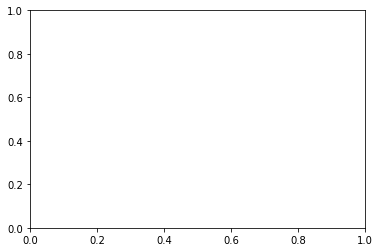

In [124]:
plt.plot(x_axis, energies)
plt.show()